<a href="https://colab.research.google.com/github/elenasofia98/PracticalNLP-2023-2024/blob/main/HoL05_1_ParaphraseClassification_LexicalFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stanza

# Recognizing Paraphrases

In [2]:
import stanza
nlp = stanza.Pipeline('en', processors='tokenize,lemma,pos,depparse')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


# MRPC (Microsoft Research Paraphrase Corpus)
Introduced by William B. Dolan et al. in Automatically Constructing a Corpus of Sentential Paraphrases
Microsoft Research Paraphrase Corpus (MRPC) is a corpus consists of 5,801 sentence pairs collected from newswire articles. Each pair is labelled if it is a paraphrase or not by human annotators. The whole set is divided into a training subset (4,076 sentence pairs of which 2,753 are paraphrases) and a test subset (1,725 pairs of which 1,147 are paraphrases).

In [3]:
!pip install datasets
from datasets import load_dataset

In [4]:
from ast import literal_eval
from datasets import Dataset, DatasetDict
import pandas as pd
import os


def parse(example, nlp):
    parsed_example = {}
    for i in [1,2]:
        parsed_sent = nlp(example[f'sentence{i}'])
        for feature in [k+str(i) for k in ['words', 'deprel', 'heads', 'headsidx', 'pos']]:
            parsed_example[feature] = []

        for sent in parsed_sent.sentences:
            for word in sent.words:
                parsed_example[f'words{i}'].append(word.text)

                parsed_example[f'deprel{i}'].append(word.deprel)

                head_idx = word.head-1
                parsed_example[f"headsidx{i}"].append(head_idx)

                head = sent.words[head_idx].text if head_idx > 0 else "root"
                parsed_example[f"heads{i}"].append(head)

                parsed_example[f"pos{i}"].append(word.upos)
    return parsed_example




if not os.path.exists('train.json') or not os.path.exists('validation.json'):
    dataset = load_dataset("glue", "mrpc",  split={"train":'train[:40%]','validation':'validation[:50%]'})
    for split in ['train', 'validation']:
        dataset[split] = dataset[split].map(lambda x: parse(x, nlp=nlp), batched=False)
        dataset[split].to_pandas().to_json(f'{split}.json')
else:

    tds = Dataset.from_pandas(pd.read_json('train.json'))
    vds = Dataset.from_pandas(pd.read_json('validation.json'))

    dataset = DatasetDict()

    dataset['train'] = tds
    dataset['validation'] = vds



display(dataset)
display(dataset['train'][0])

Map:   0%|          | 0/1467 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'words1', 'deprel1', 'heads1', 'headsidx1', 'pos1', 'words2', 'deprel2', 'heads2', 'headsidx2', 'pos2'],
        num_rows: 1467
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'words1', 'deprel1', 'heads1', 'headsidx1', 'pos1', 'words2', 'deprel2', 'heads2', 'headsidx2', 'pos2'],
        num_rows: 204
    })
})

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0,
 'words1': ['Amrozi',
  'accused',
  'his',
  'brother',
  ',',
  'whom',
  'he',
  'called',
  '"',
  'the',
  'witness',
  '"',
  ',',
  'of',
  'deliberately',
  'distorting',
  'his',
  'evidence',
  '.'],
 'deprel1': ['nsubj',
  'root',
  'nmod:poss',
  'obj',
  'punct',
  'obj',
  'nsubj',
  'acl:relcl',
  'punct',
  'det',
  'xcomp',
  'punct',
  'punct',
  'mark',
  'advmod',
  'advcl',
  'nmod:poss',
  'obj',
  'punct'],
 'heads1': ['accused',
  'root',
  'brother',
  'accused',
  'brother',
  'called',
  'called',
  'brother',
  'witness',
  'witness',
  'called',
  'witness',
  'distorting',
  'distorting',
  'distorting',
  'accused',
  'evidence',
  'distorting',
  'accused'],
 'headsidx1': [1,
  -1,
  3

In [5]:
len(dataset['train']), len(dataset['validation'])

(1467, 204)

https://aclanthology.org/U06-1019.pdf
## Using Dependency-Based Features to Take the “Para-farce” out of Paraphrase

"We propose that an automatic classifier be employed to identify and filter out inconsistent novel
sentences. To do so, we couch Paraphrase Classification as a supervised machine learning task and
train a classifier on the Microsoft Research Paraphrase (MSR) Corpus (Dolan et al., 2004), a corpus specifically collected for this task. In particular, we are especially interested in exploring the
use of syntactic dependency information in making this classification.
[...]
In this paper, we decided to explore features encoding information about the relative difference
between the structures of the two sentence.
We
thus experimented with a range of features ranging
from differences in sentence length, to word overlap, to syntax dependency tree overlap, where the
latter approximately represent predicate and argument structure.

1. **unigram recall**
2. **unigram precision**
3. lemmatised unigram precision
4. lemmatised unigram recall
5. Bleu precision
6. Bleu recall
7. lemmatised Bleu precision
8. lemmatised Bleu recall
9. fmeasure
10. **dependency relation precision**
11. **dependency relation recall**
12. lemmatised dependency relation precision
13. lemmatised dependency relation recall
14. **tree-edit distance (Zhang and Sasha algorithm)**
15. lemmatised tree-edit distance (Zhang and Sasha algorithm)
16. difference in sentence length (in words)
17. absolute difference in sentence length (in words)
"

In [6]:
import pandas as pd

TRAIN = 'train'
TEST = 'validation'

splits = [TRAIN, TEST]
X = {split: pd.DataFrame([]) for split in splits}

In [7]:
def overlap(s1, s2):
    s1 = set(s1)
    s2 = set(s2)

    return len(s1.intersection(s2))

#### Lexical features

In [8]:
# precision = word-overlap(sentence1,sentence2)/word-count(sentence1)
# recall = word-overlap(sentence1,sentence2)/word-count(sentence2)

for split in splits:
    X[split]['precision']   = [overlap(example['words1'], example['words2'])/len(set(example['words1'])) for example in dataset[split]]
    X[split]['recall']      = [overlap(example['words2'], example['words1'])/len(set(example['words2'])) for example in dataset[split]]

In [9]:
# A relation is simply a pair of words in a parent-child relationship within the dependency tree, refered to as head-modifier relationships.
# In this paper, we ignored the label of the relationships which indicates the semantic role.
# The next series of features examines the use of features based on an overlap of such head-modifier relations (hereafter, relations) between sentences.

#### Dependency overlap

In [10]:
# Feature 10 is the precision score calculated from the overlap according to the following formula:
# precisiond (dependency precision) = |relations(sentence1) ∩ relations(sentence2)|/|relations(sentence1)|
# where relations(sentence_i) is the set of headmodifier relations for some sentence.

def relations(example, sentence_index):
    rels = []
    for i in range(len(example[f"words{sentence_index}"])):
        rels.append((example[f"words{sentence_index}"][i],example[f"heads{sentence_index}"][i]))
    return rels

In [11]:
for split in splits:
    precisiond = []
    recalld = []
    for example in dataset[split]:
        relations1 = relations(example, 1)
        relations2 = relations(example, 2)

        precisiond.append(overlap(relations1, relations2)/len(set(relations1)))
        recalld.append(overlap(relations2, relations1)/len(set(relations2)))
    X[split]['precisiond'] = precisiond
    X[split]['recalld'] = recalld

#### Tree edit distance

In [12]:
# Including tree edit
# As another measure of how alike or different the two sentences are from each other,
# we decided to examine how similar their respective dependency trees were.
# Ordered tree-edit distance algorithms
# are designed to find the least costly set of operations that will transform one tree into another.
# In our case, we want to find the cost of transforming
# dependency parse trees

In [13]:
# Our implementation is based on the dynamic
# programming algorithm of Zhang and Shasha (1989).
# The algorithm finds the optimum (cheapest) set of tree-edit operations in polynomial time.
# This algorithm has been used in the past in
# Question-Answering as a means of scoring similarity between questions an candidate answers
! pip install zss

In [14]:
from zss import simple_distance, Node

In [15]:
def get_dtree(example, sentence_index):
    dtree = {}
    for i in range(len(example[f'words{sentence_index}'])):

        head = example[f'heads{sentence_index}'][i]
        head_idx = example[f'headsidx{sentence_index}'][i]
        if f"{head}_{head_idx}" not in dtree:
            dtree[f"{head}_{head_idx}"] = []

        dtree[f"{head}_{head_idx}"].append(f"{example[f'words{sentence_index}'][i]}_{i}")
    return dtree

def construct_tree(root, dtree):
    tree = Node(root)

    # is leaf
    if root not in dtree:
        return tree

    # has children
    children = dtree[root]
    for child in children:
        subtree = construct_tree(root=child, dtree=dtree) # recursevely, build the subtree rooted in each children
        tree = tree.addkid(subtree)

    return tree

In [16]:
# We calculated the tree-edit distance over the syntactic dependency parse trees.
# Inserting, deleting and renaming nodes, or words,
# into a dependency tree, were all given an equal cost.
# The cost returned by the algorithm is simply the
# sum of all operations required to transform one
# tree into the other. This cost was normalised by
# the number nodes in the target dependency tree to
# produce a value between 0 and 1

In [17]:
from tqdm import tqdm

In [18]:
root='root_-1'
for split in splits:
    ted = []
    for example in tqdm(dataset[split]):
        tree1 = construct_tree(root=root, dtree=get_dtree(example, sentence_index=1))
        tree2 = construct_tree(root=root, dtree=get_dtree(example, sentence_index=2))

        ted.append(simple_distance(tree1, tree2)/len(example['words2']))

    X[split]['ted'] = ted

100%|██████████| 204/204 [00:08<00:00, 23.54it/s]


#### Classifier

In [19]:
for split in splits:
    X[split]['target'] = [example['label'] for example in dataset[split]]

In [20]:
X[TRAIN]

,precision,recall,precisiond,recalld,ted,target
0,0.812500,0.722222,0.666667,0.631579,3.400000,1
1,0.647059,0.578947,0.294118,0.238095,4.318182,0
2,0.777778,0.736842,0.523810,0.523810,4.818182,1
3,0.576923,0.750000,0.357143,0.476190,6.190476,0
4,0.545455,0.571429,0.208333,0.227273,4.695652,1
...,...,...,...,...,...,...
1462,0.566667,0.607143,0.343750,0.366667,4.645161,0
1463,0.821429,0.766667,0.793103,0.741935,3.437500,1
1464,0.764706,0.650000,0.294118,0.227273,5.136364,0
1465,0.714286,1.000000,0.565217,0.812500,4.647059,1


In [96]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=3.0, kernel='poly', degree=3)


X_train = X[TRAIN][[feature for feature in X[TRAIN].columns if feature!='target']]
y_train = X[TRAIN]['target']


SVM.fit(X_train, y_train)

SVC(C=3.0, kernel='poly')

In [97]:
pred_train = SVM.predict(X_train)

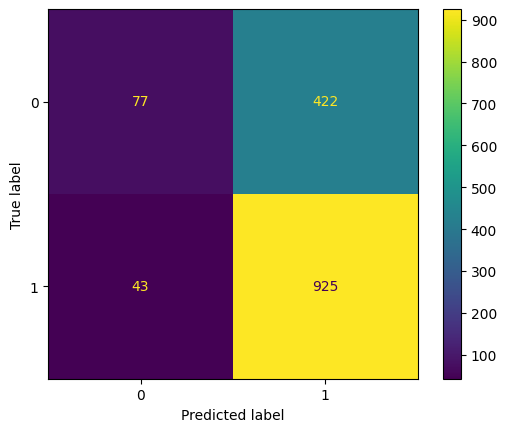

In [98]:
cm = confusion_matrix(y_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

In [99]:
print(classification_report(y_pred=pred_train, y_true=y_train))

              precision    recall  f1-score   support

           0       0.64      0.15      0.25       499
           1       0.69      0.96      0.80       968

    accuracy                           0.68      1467
   macro avg       0.66      0.55      0.52      1467
weighted avg       0.67      0.68      0.61      1467



In [100]:
X_test = X[TEST][[feature for feature in X[TEST].columns if feature!='target']]
y_test = X[TEST]['target']

pred_test = SVM.predict(X_test)

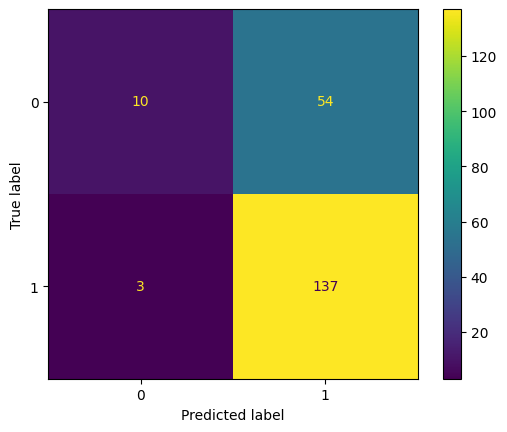

In [101]:
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

In [102]:
print(classification_report(y_pred=pred_test, y_true=y_test))

              precision    recall  f1-score   support

           0       0.77      0.16      0.26        64
           1       0.72      0.98      0.83       140

    accuracy                           0.72       204
   macro avg       0.74      0.57      0.54       204
weighted avg       0.73      0.72      0.65       204



## Lexical Models
SOL 1) Lets analyze words:
- Bag of Words (BOW) with One Hot Encoding for words, only for content words

SOL 2) map each word to its "meaning". Synset for each word? Nope, for content words
- Bag of Synsets: for each content word, the synsets for that words

SOL 2.5) Paraphrases share a common lexicon
- Words that appear in a sentence and do/do not appear in the other, "subtraction" of words

SOL 3) map each word to its "meaning", hand crafcted features
- Words with the same syntactic role does have the same synset
- Do predicates have the same synset? Is their meaning at least similar?
- **Having the same syntactic role** for example subjs and objs, compute cross similarities


### BOW

In [103]:
tokens = set([token for i in range(len(dataset['train']))
            for token in dataset['train'][i]['words1'] + dataset['train'][i]['words2']])
len(tokens)

8860

In [104]:
import nltk
nltk.download('stopwords')


from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
vocabulary = list(set([token.lower() for token in tokens if token not in stop_words]))
len(vocabulary)

8108

In [106]:
class Vocab:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.stoi = {vocabulary[i]:i+1 for i in range(len(vocabulary))}
        self.itos = [vocabulary[i] for i in range(len(vocabulary))]

        self.stoi['[UNK]'] = 0
        self.itos = ['[UNK]'] + self.itos

    def vocab_size(self):
        return len(self.itos)

    def __getitem__(self, key: str):
        if key in self.stoi:
            return self.stoi[key]

        return self.stoi['[UNK]']

    def decode(self, index:int):
        if index in self.itos:
            return self.itos[index]
        return self.itos[0]

In [107]:
vocab = Vocab(vocabulary)
len(vocabulary), len(vocab.itos), len(vocab.stoi.keys())

(8108, 8109, 8109)

In [108]:
import numpy as np

X_lexicals = {}

for split in ['train', 'validation']:
    X_lexicals[split] = []
    for i in tqdm(range(len(dataset[split]))):
        bows = []

        for si in [1,2]:
            bow = [0 for i in range(vocab.vocab_size())]

            for word in dataset[split][i][f'words{si}']:
                word = word.lower()

                idx = vocab[word]

                bow[idx] +=1

            bow = np.array(bow)
            bow =  bow/np.sum(bow)

            bows.extend(bow.tolist())

        X_lexicals[split].append(bows)


100%|██████████| 204/204 [00:01<00:00, 186.26it/s]


In [109]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42, svd_solver='full')
pca.fit(X_lexicals['train'])
explained_in_top = np.cumsum(pca.explained_variance_ratio_)
#print(pca.singular_values_)

In [110]:
np.array(X_lexicals['train']).shape, np.array(X_lexicals['validation']).shape

((1467, 16218), (204, 16218))

In [111]:
len(pca.explained_variance_ratio_)

1467

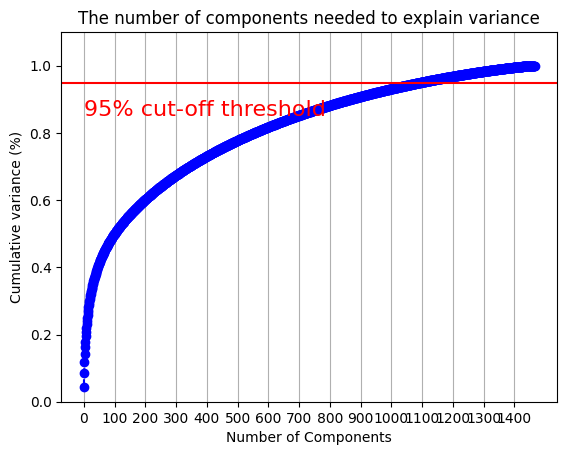

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.ylim(0.0,1.1)


xi = np.arange(0, len(explained_in_top), step=1)
plt.plot(xi, explained_in_top, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(explained_in_top), step=100))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [114]:
num_components = len(explained_in_top) - len(explained_in_top[explained_in_top>0.95])
num_components

1095

In [115]:
X_lexicals['train'] = pca.transform(X_lexicals['train'])[:,:num_components]
X_lexicals['validation'] = pca.transform(X_lexicals['validation'])[:,:num_components]
print(X_lexicals['train'].shape, X_lexicals['validation'].shape)

(1467, 1095) (204, 1095)


#### Classifier

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       499
           1       0.99      1.00      0.99       968

    accuracy                           0.99      1467
   macro avg       0.99      0.99      0.99      1467
weighted avg       0.99      0.99      0.99      1467



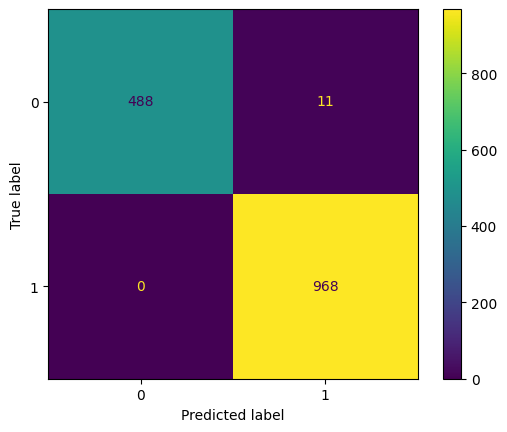

In [117]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=3.0, kernel='poly', degree=3)


X_train = X_lexicals['train']
y_train = X['train']['target']


SVM.fit(X_train, y_train)

pred_train = SVM.predict(X_train)

cm = confusion_matrix(y_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

print(classification_report(y_pred=pred_train, y_true=y_train))

In [118]:
len(pred_test)

204

              precision    recall  f1-score   support

           0       0.71      0.08      0.14        64
           1       0.70      0.99      0.82       140

    accuracy                           0.70       204
   macro avg       0.71      0.53      0.48       204
weighted avg       0.70      0.70      0.61       204



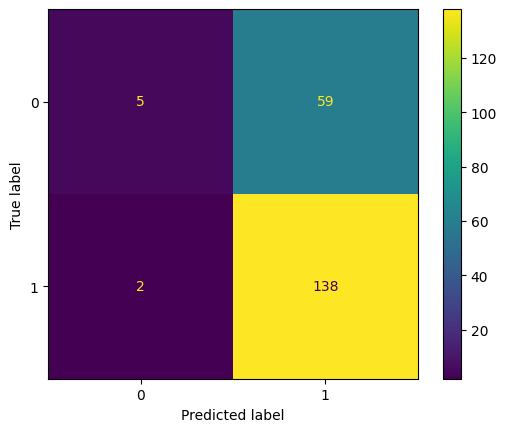

In [119]:
X_test = X_lexicals['validation']
y_test = X['validation']['target']

pred_test = SVM.predict(X_test)

cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

print(classification_report(y_pred=pred_test, y_true=y_test))

### Bag of synsets

In [120]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [121]:
from nltk.corpus import wordnet as wn


pos_map = {
    'ADJ': ['a', 's'],
    'NOUN': ['n'],
    'VERB':  ['v'],
    'ADV': ['r'],
    'PROPN':['n']
}
from tqdm import tqdm

def add_synset(example):
    synsets = {}

    for si in [1,2]:
        synsets[si] = {}

        for i in range(len(example[f'pos{si}'])):
            pt = example[f'pos{si}'][i]
            if pt not in pos_map:
                continue

            word = example[f'words{si}'][i]
            for wn_pt in pos_map[pt]:
                for word_synset in wn.synsets(word, pos=wn_pt):
                    if word_synset.name() not in synsets:
                        synsets[si][word_synset.name()] = 0
                    synsets[si][word_synset.name()] +=1
    return synsets




def create_synset(dataset_split):
    synsets = []
    for example in tqdm(dataset_split):
        example_syns = add_synset(example)
        concat_syns = {f'{si}-{synname}': example_syns[si][synname]
                       for si in [1,2] for synname in example_syns[si]}

        synsets.append(concat_syns)
    return synsets



X_synsets = {}

for split in ['train', 'validation']:
    X_synsets[split] = create_synset(dataset[split])

100%|██████████| 204/204 [00:00<00:00, 1128.45it/s]


In [122]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
v.fit(X_synsets['train'])

for split in ['train', 'validation']:
    X_synsets[split] = v.transform(X_synsets[split])

    row_sums = X_synsets[split].sum(axis=1)

    X_synsets[split] = X_synsets[split]/ row_sums[:, np.newaxis]

In [123]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42, svd_solver='full')
pca.fit(X_synsets['train'])
explained_in_top = np.cumsum(pca.explained_variance_ratio_)
#print(pca.singular_values_)

In [124]:
num_components = len(explained_in_top) - len(explained_in_top[explained_in_top>0.95])

X_synsets['train'] = pca.transform(X_synsets['train'])[:,:num_components]
X_synsets['validation'] = pca.transform(X_synsets['validation'])[:,:num_components]
print(X_synsets['train'].shape, X_synsets['validation'].shape)

(1467, 934) (204, 934)


#### Classifier

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       499
           1       0.91      1.00      0.95       968

    accuracy                           0.94      1467
   macro avg       0.96      0.90      0.92      1467
weighted avg       0.94      0.94      0.93      1467



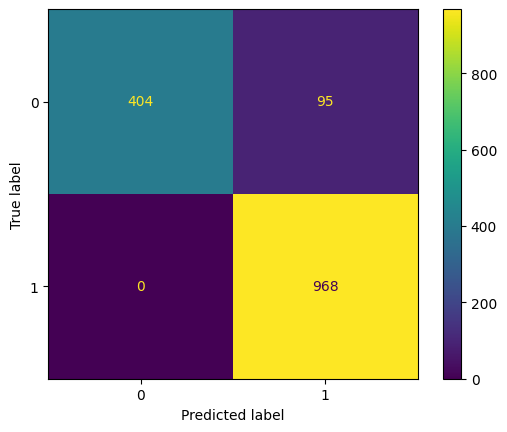

In [125]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=3.0, kernel='poly', degree=3)


X_train = X_synsets['train']
y_train = X['train']['target']


SVM.fit(X_train, y_train)

pred_train = SVM.predict(X_train)

cm = confusion_matrix(y_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

print(classification_report(y_pred=pred_train, y_true=y_train))

              precision    recall  f1-score   support

           0       0.80      0.06      0.12        64
           1       0.70      0.99      0.82       140

    accuracy                           0.70       204
   macro avg       0.75      0.53      0.47       204
weighted avg       0.73      0.70      0.60       204



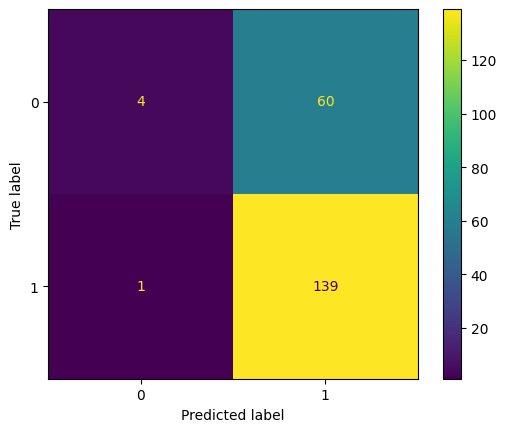

In [126]:
X_test = X_synsets['validation']
y_test = X['validation']['target']

pred_test = SVM.predict(X_test)

cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

print(classification_report(y_pred=pred_test, y_true=y_test))

### Syntactically-filtered semantic features

In [127]:
### 1) words in the same role in the different sentences have have the similar synset
### 2) Do predicates have the same synset? Is their meaning at least similar?
########## Is "included" in the previous ones, that is, root word are similar
### 3) Swap subjs and objs specific for active and passive forms

<BarContainer object of 49 artists>

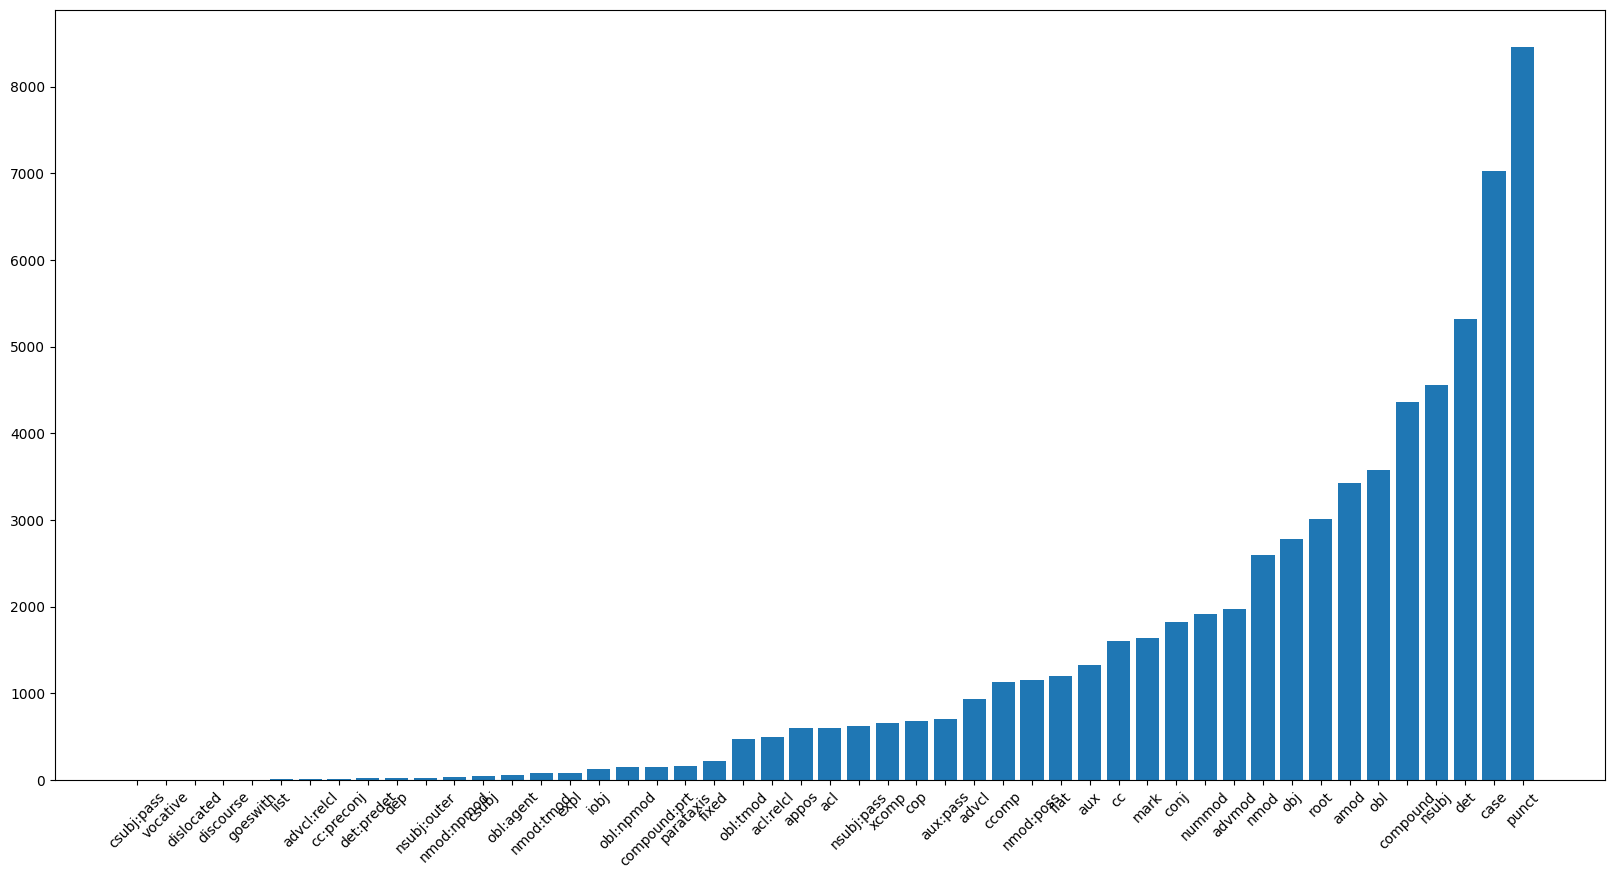

In [128]:
import matplotlib.pyplot as plt

train_deps = {}

for example in dataset['train']:
    for si in [1,2]:
        for dep in example[f'deprel{si}']:
            if dep not in train_deps:
                train_deps[dep] = 0
            train_deps[dep]+=1

sd = dict(sorted(train_deps.items(), key=lambda item: item[1]))
fig =plt.figure(figsize=(20,10))
plt.xticks(rotation = 45)
plt.bar([k for k in sd], height=[sd[k] for k in sd], figure=fig)

In [129]:
dataset['train'][0].keys()

dict_keys(['sentence1', 'sentence2', 'label', 'idx', 'words1', 'deprel1', 'heads1', 'headsidx1', 'pos1', 'words2', 'deprel2', 'heads2', 'headsidx2', 'pos2'])

In [130]:
def get_all_synsets(word, pt):
    ss = set()

    for wn_pt in pos_map[pt]:
        for word_synset in wn.synsets(word, pos=wn_pt):
                ss.add(word_synset)
    return ss

In [131]:
X_deprel = {}

for split in ['train', 'validation']:
    X_deprel[split] = []

    for example in tqdm(dataset[split]):
        rels_ex_features = {}
        rels = set(example[f'deprel1']).intersection(set(example[f'deprel2'])) # find common rels

        for rel in rels: # for each relation that is in common
            indices = {si: [i for i, x in enumerate(example[f'deprel{si}']) if x == rel] for si in [1,2]} # find indices of words that have that relation

            avg_sim = []
            for i in indices[1]:
                for j in indices[2]:
                    #print(example['deprel1'])
                    pos_tags = {1: example["pos1"][i], 2:example["pos2"][j]}
                    #print(pos_tags)
                    words = {1:example['words1'][i], 2: example['words2'][j]}
                    #print(words)

                    if pos_tags[1] in pos_map and pos_tags[2] in pos_map and pos_tags[1] == pos_tags[2]: # if it is a content word
                        # collect all synsets
                        synsets = {}
                        for si in [1,2]:
                            synsets[si] = get_all_synsets(words[si], pos_tags[si])

                        if len(synsets[1]) != 0 and len(synsets[2]) != 0:
                            for s1 in synsets[1]:
                                for s2 in synsets[2]:
                                    avg_sim.append(wn.path_similarity(s1, s2))
                        else:
                            avg_sim.append(0)


            #print(rel, indices)
            if len(avg_sim) != 0:
                avg_sim = max(avg_sim)
                rels_ex_features[rel] = avg_sim

        X_deprel[split].append(rels_ex_features)

100%|██████████| 204/204 [00:09<00:00, 21.94it/s]


In [132]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False)
v.fit(X_deprel['train'])
X_deprel2 = {}
for split in ['train', 'validation']:
    X_deprel2[split] = v.transform(X_deprel[split])

#### Classifier

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       499
           1       0.86      0.85      0.86       968

    accuracy                           0.81      1467
   macro avg       0.79      0.79      0.79      1467
weighted avg       0.81      0.81      0.81      1467



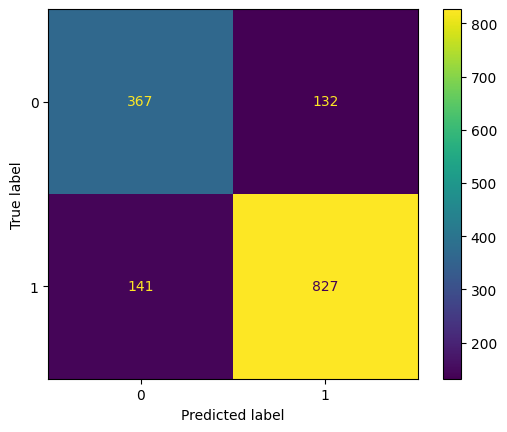

In [133]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=3.0, kernel='poly', degree=3)


X_train = X_deprel2['train']
y_train = X['train']['target']


SVM.fit(X_train, y_train)

pred_train = SVM.predict(X_train)

cm = confusion_matrix(y_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

print(classification_report(y_pred=pred_train, y_true=y_train))

              precision    recall  f1-score   support

           0       0.39      0.34      0.36        64
           1       0.71      0.75      0.73       140

    accuracy                           0.62       204
   macro avg       0.55      0.55      0.55       204
weighted avg       0.61      0.62      0.62       204



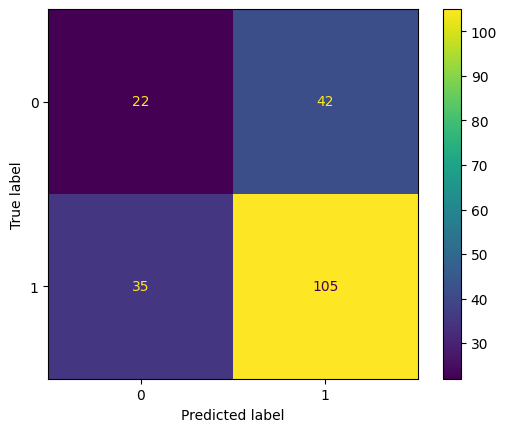

In [134]:
X_test = X_deprel2['validation']
y_test = X['validation']['target']

pred_test = SVM.predict(X_test)

cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

print(classification_report(y_pred=pred_test, y_true=y_test))